In [6]:
#Importing required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix,roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import preprocessing
import xgboost as xgb
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import uniform,randint


In [7]:
#Reading the dataset
df_train = pd.read_csv("Training Data.csv")
df_test = pd.read_csv("Test Data.csv")

# Data Profiling

In [8]:
print(df_train.shape)
print(df_test.shape)

(6296, 18)
(1080, 18)


In [9]:
df_train.isnull().sum()

SLNO                           0
Candidate Ref                  0
DOJ Extended                   0
Duration to accept offer       0
Notice period                  0
Offered band                   0
Pecent hike expected in CTC    0
Percent hike offered in CTC    0
Percent difference CTC         0
Joining Bonus                  0
Candidate relocate actual      0
Gender                         0
Candidate Source               0
Rex in Yrs                     0
LOB                            0
Location                       0
Age                            0
Status                         0
dtype: int64

In [10]:
df_train.drop(['SLNO','Candidate Ref'],axis=1).describe()

,Duration to accept offer,Notice period,Pecent hike expected in CTC,Percent hike offered in CTC,Percent difference CTC,Rex in Yrs,Age
count,6296.000000,6296.000000,6296.000000,6296.000000,6296.000000,6296.000000,6296.000000
mean,21.413119,39.475064,44.043980,40.645801,-1.714808,4.238088,29.941074
std,25.902967,22.007797,30.545948,36.589521,19.423642,2.546287,4.057943
min,0.000000,0.000000,-62.500000,-60.530000,-66.670000,0.000000,20.000000
25%,3.000000,30.000000,27.270000,21.880000,-8.570000,3.000000,27.000000
50%,9.000000,30.000000,40.000000,35.860000,0.000000,4.000000,30.000000
75%,33.000000,60.000000,54.037500,50.000000,0.000000,6.000000,34.000000
max,224.000000,120.000000,359.770000,471.430000,300.000000,24.000000,50.000000


**Observation:**
* Percent hike expected has a minimum value of -68%.
* Percent hike offered has a minimum value of -60%.
* It seems like some people have offered less CTC than previous CTC

# Data preparation and analysis

In [11]:
#Encoding the target variable
df_train['Status'] = np.where(df_train['Status'] == 'Joined', 1, 0)
df_test['Status'] = np.where(df_test['Status'] == 'Joined', 1, 0)

Observation:
* Joined = 1
* Not joined = 0

In [12]:
#Dropping SLNO , Candidate Ref and Location because of high cardinality
df_train.drop(['SLNO','Candidate Ref','Location'],axis=1,inplace=True)
df_test.drop(['SLNO','Candidate Ref','Location'],axis=1,inplace=True)

#Correlation map for training data
df_train.corr().style.background_gradient(cmap='coolwarm')

,Duration to accept offer,Notice period,Pecent hike expected in CTC,Percent hike offered in CTC,Percent difference CTC,Rex in Yrs,Age,Status
Duration to accept offer,1.000000,0.354864,0.021113,0.012202,-0.004422,0.105648,0.011136,-0.072932
Notice period,0.354864,1.000000,-0.000581,-0.015999,-0.024190,0.178257,-0.020829,-0.175371
Pecent hike expected in CTC,0.021113,-0.000581,1.000000,0.676502,-0.156460,-0.219504,-0.136061,-0.009722
Percent hike offered in CTC,0.012202,-0.015999,0.676502,1.000000,0.600194,-0.111991,-0.076174,0.024593
Percent difference CTC,-0.004422,-0.024190,-0.156460,0.600194,1.000000,0.086750,0.045246,0.041948
Rex in Yrs,0.105648,0.178257,-0.219504,-0.111991,0.086750,1.000000,0.555119,-0.026525
Age,0.011136,-0.020829,-0.136061,-0.076174,0.045246,0.555119,1.000000,0.063921
Status,-0.072932,-0.175371,-0.009722,0.024593,0.041948,-0.026525,0.063921,1.000000


**Observation**
* Percent hike offered in CTC and Pecent hike expected in CTC are positively correlated
* Percent hike offered in CTC and Percent difference CTC are also positively correlated
* Also, Notice period and Duration to accept offer are slightly positive correlated.  So, more the duration of notice period, more the time candiate take to accept the offer
* Notice period and Status are slightly negatively correlated. It means more the duration of notice period, there are high chances that the candidate may not join 


In [13]:
#Checking uniques values in each columns
for col in df_train.columns:
  print(col," - ",df_train[col].unique())

DOJ Extended  -  ['Yes' 'No']
Duration to accept offer  -  [ 14   3  26   1  17  16   6 120   7  98   0  83  32   4  38  24  10  53
   5  46   2  31  54  33 105  19  84  90  21  34  13   8  42  12  69  37
  60  23  67  15  45  36  11  48  74  30  40  20  58  29  50  39  57  55
  71  18  66  62  25  28  64  27  78  22  49   9  61  77  82  80  97  59
  41  88  70  63  51  86 111  87  43  52  96  91  35 101  79  68  65  93
  76  99  73 123  44 104 126 117 109  47 127  81  85  75 118 114  56 103
  92 110 124  72 116 129 121  94 119 102  95 107 125 131 100 130  89 113
 224 108 106 163]
Notice period  -  [ 30  45 120   0  60  75  90]
Offered band  -  ['E2' 'E1' 'E3' 'E0']
Pecent hike expected in CTC  -  [-20.79  42.84  42.59 ...  45.52   6.15  96.85]
Percent hike offered in CTC  -  [13.16 42.84 42.59 ... 63.89 35.2  45.52]
Percent difference CTC  -  [ 4.2860e+01  0.0000e+00 -5.8800e+00 -6.2500e+01  1.5833e+02 -2.5000e+00
  7.6910e+01  6.5000e+01 -1.7780e+01 -2.9170e+01  4.0000e+00 -6.2500e+0

# Data Encoding

In [14]:
#Encoding offered bands feature
offered_bands = {"Offered band":{"E0":1,"E1":2,"E2":3,"E3":4}}
df_train.replace(offered_bands,inplace=True)

In [15]:
df_test.replace(offered_bands,inplace=True)

In [16]:
#Encoding categorical columns
df_train_encoded = pd.get_dummies(df_train,drop_first=True)
df_test_encoded = pd.get_dummies(df_test,drop_first=True)


In [17]:
# df_train_encoded['offered_greater_expected'] = np.where(df_train_encoded['Percent hike offered in CTC'] > df_train_encoded['Pecent hike expected in CTC'], 1, 0)
# df_test_encoded['offered_greater_expected'] = np.where(df_test_encoded['Percent hike offered in CTC'] > df_test_encoded['Pecent hike expected in CTC'], 1, 0)

In [18]:
df_train_encoded.corr().style.background_gradient(cmap='coolwarm')


,Duration to accept offer,Notice period,Offered band,Pecent hike expected in CTC,Percent hike offered in CTC,Percent difference CTC,Rex in Yrs,Age,Status,DOJ Extended_Yes,Joining Bonus_Yes,Candidate relocate actual_Yes,Gender_Male,Candidate Source_Direct,Candidate Source_Employee Referral,LOB_BFSI,LOB_CSMP,LOB_EAS,LOB_ERS,LOB_ETS,LOB_Healthcare,LOB_INFRA,LOB_MMS
Duration to accept offer,1.000000,0.354864,0.029516,0.021113,0.012202,-0.004422,0.105648,0.011136,-0.072932,0.334515,0.032914,0.008436,0.018579,0.000034,-0.044605,0.122515,0.003961,0.033757,0.029223,0.026913,0.013310,-0.194166,0.010313
Notice period,0.354864,1.000000,0.155257,-0.000581,-0.015999,-0.024190,0.178257,-0.020829,-0.175371,0.146987,0.017890,-0.064549,0.043478,-0.000467,-0.031516,0.081745,0.007739,0.031585,0.015139,0.030576,0.004385,-0.139901,0.023345
Offered band,0.029516,0.155257,1.000000,-0.169219,-0.037223,0.132464,0.710718,0.438655,0.029500,0.064130,0.072399,0.024385,0.175478,-0.028043,0.138561,-0.112593,-0.105589,0.056905,-0.148801,-0.007958,-0.028675,0.277155,-0.028809
Pecent hike expected in CTC,0.021113,-0.000581,-0.169219,1.000000,0.676502,-0.156460,-0.219504,-0.136061,-0.009722,-0.009026,-0.038456,-0.003176,-0.003561,-0.037178,-0.009734,-0.056912,0.026112,-0.039486,0.163206,-0.022021,-0.021568,-0.073313,0.011898
Percent hike offered in CTC,0.012202,-0.015999,-0.037223,0.676502,1.000000,0.600194,-0.111991,-0.076174,0.024593,-0.011090,-0.031956,0.020532,0.009301,-0.019668,0.001604,-0.072486,-0.001627,-0.030704,0.092712,0.004992,-0.012238,0.009728,0.014318
Percent difference CTC,-0.004422,-0.024190,0.132464,-0.156460,0.600194,1.000000,0.086750,0.045246,0.041948,-0.002080,-0.005781,0.028243,0.014516,0.011760,0.011123,-0.036707,-0.027138,-0.000740,-0.040912,0.022447,0.003078,0.088434,0.004168
Rex in Yrs,0.105648,0.178257,0.710718,-0.219504,-0.111991,0.086750,1.000000,0.555119,-0.026525,0.094475,0.118814,0.006748,0.143541,-0.016318,0.077513,0.022679,-0.038902,0.120461,-0.044577,0.075418,0.005184,-0.103740,-0.013685
Age,0.011136,-0.020829,0.438655,-0.136061,-0.076174,0.045246,0.555119,1.000000,0.063921,0.055534,0.109893,0.070194,0.124798,-0.014368,0.062139,0.010992,-0.013161,0.099280,-0.073842,0.061918,0.000081,-0.054380,-0.035880
Status,-0.072932,-0.175371,0.029500,-0.009722,0.024593,0.041948,-0.026525,0.063921,1.000000,0.013678,0.003746,0.192774,-0.007090,0.015318,0.072693,-0.057504,-0.002912,-0.039314,-0.042495,0.011353,-0.001249,0.112239,0.022637
DOJ Extended_Yes,0.334515,0.146987,0.064130,-0.009026,-0.011090,-0.002080,0.094475,0.055534,0.013678,1.000000,0.061934,0.012266,0.006561,0.007194,0.002536,-0.096905,0.014348,0.158401,0.073701,0.077366,0.006964,-0.141634,0.003277


In [19]:
df_train_encoded[['Duration to accept offer','Notice period','Offered band','Status']].corr().style.background_gradient(cmap='coolwarm')

,Duration to accept offer,Notice period,Offered band,Status
Duration to accept offer,1.000000,0.354864,0.029516,-0.072932
Notice period,0.354864,1.000000,0.155257,-0.175371
Offered band,0.029516,0.155257,1.000000,0.029500
Status,-0.072932,-0.175371,0.029500,1.000000


**Observation:**
* Dropping Pecent hike expected in CTC and Percent hike offered in CTC column to avoid multicollinearity issues

In [20]:
df_train_encoded1 = df_train_encoded.drop(['Pecent hike expected in CTC','Percent hike offered in CTC'],axis=1)
df_test_encoded1=df_test_encoded.drop(['Pecent hike expected in CTC','Percent hike offered in CTC'],axis=1)

In [21]:

from statsmodels.stats.outliers_influence import variance_inflation_factor 
X = df_train_encoded.drop(['Status'],axis=1)
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
print(vif_data)                          

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                               feature        VIF
0             Duration to accept offer   2.198435
1                        Notice period   4.971470
2                         Offered band  40.627238
3          Pecent hike expected in CTC  65.049557
4          Percent hike offered in CTC  71.556346
5               Percent difference CTC  17.939770
6                           Rex in Yrs   9.699736
7                                  Age  35.666232
8                     DOJ Extended_Yes   2.241783
9                    Joining Bonus_Yes   1.123396
10       Candidate relocate actual_Yes   1.219103
11                         Gender_Male   5.954099
12             Candidate Source_Direct   2.962489
13  Candidate Source_Employee Referral   1.712277
14                            LOB_BFSI   3.164050
15                            LOB_CSMP   1.921391
16                             LOB_EAS   1.550225
17                             LOB_ERS   4.686214
18                             LOB_ETS   2.002107


In [22]:
df_train_encoded1.drop(['LOB_MMS'],axis=1,inplace=True)

In [23]:
df_train_encoded1.shape

(6296, 20)

In [24]:
X_train = df_train_encoded1.drop(['Status'],axis=1)
y_train = df_train_encoded1['Status']
X_test = df_test_encoded1.drop(['Status'],axis=1)
y_test = df_test_encoded1['Status']

In [25]:
X_train.shape

(6296, 19)

# Model Selection and Building

In [26]:
#Function to perform hyper parameters tuning using gridsearchcv
def hyper_parameters_tuning(model,X,y):
  scores = []
  for model_name, mp in model.items():
      clf =  GridSearchCV(mp['model'],mp['params'] ,cv= 2, return_train_score=False)
      clf.fit(X, y)
      scores.append({
          'model': model_name,
          'best_score': clf.best_score_,
          'best_params':clf.best_params_
      })
      
  df_model = pd.DataFrame(scores,columns=['model','best_score','best_params'])
  return df_model

**Logistic Regression**

In [27]:
model = {
    'Logistic Regression':{'model':LogisticRegression(),'params':{'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                                                                           'max_iter':[80,100,150]}}
}

In [28]:
result=hyper_parameters_tuning(model,X_train,y_train)
result

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,model,best_score,best_params
0,Logistic Regression,0.814803,"{'max_iter': 100, 'solver': 'saga'}"


In [29]:

model = LogisticRegression(max_iter=100,solver='saga')
model.fit(X_train,y_train)
ypred = model.predict(X_test)
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       202
           1       0.81      1.00      0.90       878

    accuracy                           0.81      1080
   macro avg       0.91      0.50      0.46      1080
weighted avg       0.85      0.81      0.73      1080



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


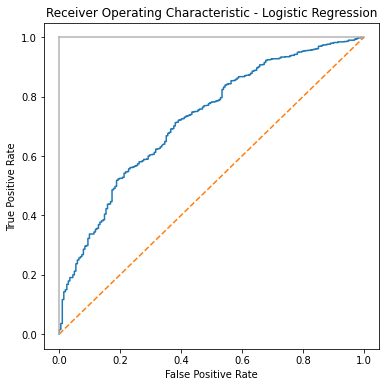

In [30]:
y_score_lg = model.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score_lg)
plt.subplots(1, figsize=(6,6))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
#Function to calculate evaluation metrics
def calculate_evaluation_metrics(tn,fp,fn,tp):
  accuracy = (tp+tn)/(tp+tn+fp+fn)
  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)
  print("Accuracy - ",accuracy)
  print("Sensitivity - ",sensitivity)
  print("Specificity - ",specificity)

In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, ypred).ravel()
print("True Negative - ", tn)
print("False Positive - ",fp)
print("False Negative - ",fn)
print("True Positive - ",tp)

True Negative -  2
False Positive -  200
False Negative -  0
True Positive -  878


In [33]:
calculate_evaluation_metrics(tn,fp,fn,tp)

Accuracy -  0.8148148148148148
Sensitivity -  1.0
Specificity -  0.009900990099009901


**Observation:**
* Accuracy for logistic regression is 81.4%

**Decision Tree Classifier**

In [34]:
model1 = {
    'Decision Tree':{'model':DecisionTreeClassifier(),'params':{'criterion':['gini', 'entropy'],
                                                                           'max_features':['auto','sqrt','log2',None]}}
}

In [35]:
result = hyper_parameters_tuning(model1,X_train,y_train)
result

,model,best_score,best_params
0,Decision Tree,0.735229,"{'criterion': 'entropy', 'max_features': None}"


In [36]:
model1 = DecisionTreeClassifier(criterion='entropy',max_features='sqrt')
model1.fit(X_train,y_train)
ypred_dt = model1.predict(X_test)
print(classification_report(y_test,ypred_dt))

              precision    recall  f1-score   support

           0       0.34      0.36      0.35       202
           1       0.85      0.84      0.85       878

    accuracy                           0.75      1080
   macro avg       0.60      0.60      0.60      1080
weighted avg       0.76      0.75      0.75      1080



In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, ypred_dt).ravel()
print("True Negative - ", tn)
print("False Positive - ",fp)
print("False Negative - ",fn)
print("True Positive - ",tp)

True Negative -  73
False Positive -  129
False Negative -  141
True Positive -  737


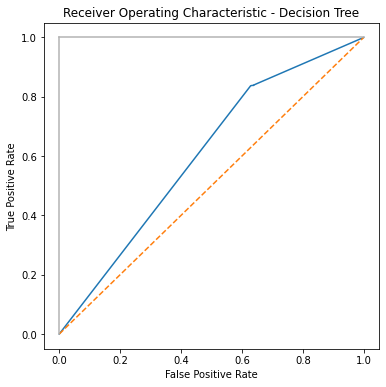

In [38]:
y_score_dt = model1.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score_dt)
plt.subplots(1, figsize=(6,6))
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
calculate_evaluation_metrics(tn,fp,fn,tp)

Accuracy -  0.75
Sensitivity -  0.8394077448747153
Specificity -  0.3613861386138614


**Observation**
* Accuracy of Decision tree classifier is 77.03%

**Random Forest**

In [40]:
model2 = {
    'Random forest':{'model':RandomForestClassifier(),'params':{'criterion':['gini', 'entropy'],
                                                                           'max_features':['auto','sqrt','log2',None]}}
}

In [41]:
result = hyper_parameters_tuning(model2,X_train,y_train)
result

,model,best_score,best_params
0,Random forest,0.811785,"{'criterion': 'gini', 'max_features': 'auto'}"


In [42]:
model2 = RandomForestClassifier(criterion='entropy',max_features='auto',class_weight='balanced')
model2.fit(X_train,y_train)
ypred_rf = model2.predict(X_test)
print(classification_report(y_test,ypred_rf))

              precision    recall  f1-score   support

           0       0.55      0.20      0.30       202
           1       0.84      0.96      0.90       878

    accuracy                           0.82      1080
   macro avg       0.70      0.58      0.60      1080
weighted avg       0.79      0.82      0.78      1080



In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, ypred_rf).ravel()
print("True Negative - ", tn)
print("False Positive - ",fp)
print("False Negative - ",fn)
print("True Positive - ",tp)

True Negative -  41
False Positive -  161
False Negative -  33
True Positive -  845


In [44]:
calculate_evaluation_metrics(tn,fp,fn,tp)

Accuracy -  0.8203703703703704
Sensitivity -  0.9624145785876993
Specificity -  0.20297029702970298


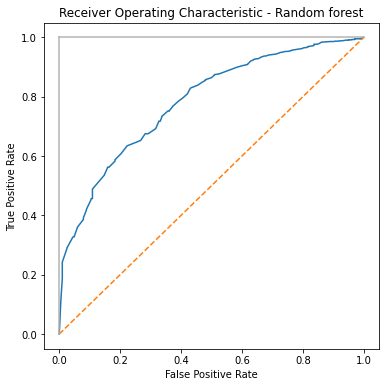

In [45]:
y_score_rf = model2.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score_rf)
plt.subplots(1, figsize=(6,6))
plt.title('Receiver Operating Characteristic - Random forest')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Observation**
* Accuracy of Random forest model is 81.66%

**Support Vector Machine**

In [46]:
model3 = {
    'SVC':{'model':svm.SVC(kernel='rbf',gamma='auto'),'params':{'C': [1,10,20]}}
}

In [47]:
result = hyper_parameters_tuning(model3,X_train,y_train)
result

,model,best_score,best_params
0,SVC,0.809244,{'C': 1}


In [48]:
model3 = svm.SVC(kernel='rbf',gamma='scale',C=1)
model3.fit(X_train,y_train)
ypred_svc = model3.predict(X_test)
print(classification_report(y_test,ypred_svc))

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       202
           1       0.81      1.00      0.90       878

    accuracy                           0.81      1080
   macro avg       0.66      0.50      0.45      1080
weighted avg       0.75      0.81      0.73      1080



In [49]:
tn, fp, fn, tp = confusion_matrix(y_test, ypred_svc).ravel()
print("True Negative - ", tn)
print("False Positive - ",fp)
print("False Negative - ",fn)
print("True Positive - ",tp)

True Negative -  1
False Positive -  201
False Negative -  1
True Positive -  877


In [50]:
calculate_evaluation_metrics(tn,fp,fn,tp)

Accuracy -  0.812962962962963
Sensitivity -  0.9988610478359908
Specificity -  0.0049504950495049506


**XGBoost Classifier**

In [51]:
params = {
   "colsample_bytree": uniform(0.3, 0.7),
   "min_child_weight": [1,2,3,4],
   "learning_rate": uniform(0.1, 0.5), # default 0.1 
   "max_depth": randint(6, 9), # default 3
   "n_estimators": randint(100, 300), # default 100
   "subsample": uniform(0.6, 0.4)
}
xgbnew = xgb.XGBClassifier()

search = RandomizedSearchCV(xgbnew, param_distributions=params, random_state=123, n_iter=100, cv=5, verbose=2, n_jobs=-1)

search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff644c17630>,
                                        'min_child_w

In [52]:
xgboost_model=search.best_estimator_

In [53]:
ypred_xgb = xgboost_model.predict(X_test)
print(classification_report(y_test,ypred_xgb))

              precision    recall  f1-score   support

           0       0.67      0.21      0.32       202
           1       0.84      0.98      0.90       878

    accuracy                           0.83      1080
   macro avg       0.75      0.59      0.61      1080
weighted avg       0.81      0.83      0.79      1080



In [54]:
tn, fp, fn, tp = confusion_matrix(y_test, ypred_xgb).ravel()
print("True Negative - ", tn)
print("False Positive - ",fp)
print("False Negative - ",fn)
print("True Positive - ",tp)

True Negative -  42
False Positive -  160
False Negative -  21
True Positive -  857


In [55]:
calculate_evaluation_metrics(tn,fp,fn,tp)

Accuracy -  0.8324074074074074
Sensitivity -  0.9760820045558086
Specificity -  0.2079207920792079


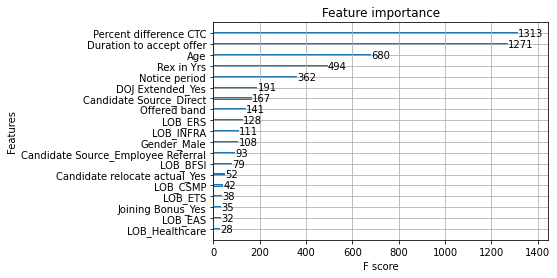

In [57]:
plot_importance(xgboost_model)

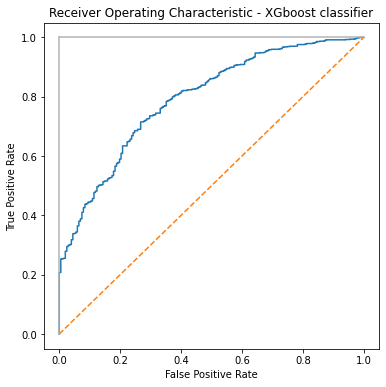

In [58]:
y_score_xg = xgboost_model.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score_xg)
plt.subplots(1, figsize=(6,6))
plt.title('Receiver Operating Characteristic - XGboost classifier')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Predicting test submission file

In [59]:
test_data = pd.read_csv("Test Data_submission.csv")
test_data.drop(['SLNO','Candidate Ref','Location'],axis=1,inplace=True)
offered_bands = {"Offered band":{"E0":1,"E1":2,"E2":3,"E3":4}}
test_data.replace(offered_bands,inplace=True)
test_data_encoded = pd.get_dummies(test_data,drop_first=True)
test_data_encoded1 = test_data_encoded.drop(['Pecent hike expected in CTC','Percent hike offered in CTC','LOB_MMS','Status'],axis=1)

In [60]:
test_data_encoded1.shape

(2699, 19)

In [61]:
pred_submission = xgboost_model.predict(test_data_encoded1)

In [62]:
result_submission = pd.DataFrame(pred_submission,columns=['Status'])
result_submission.head()

,Status
0,1
1,1
2,1
3,0
4,1


In [63]:
#Decoding the target variable
result_submission['Status'] = np.where(result_submission['Status'] == 1, 'Joined', 'Not Joined')

In [64]:
result_submission.head()

,Status
0,Joined
1,Joined
2,Joined
3,Not Joined
4,Joined


In [65]:
final_submission = pd.read_csv("Test Data_submission.csv")
final_submission.drop(['Status'],axis=1,inplace=True)

In [66]:
final_submission.shape

(2699, 17)

In [67]:
result_submission.shape

(2699, 1)

In [68]:
final_submission_1 = pd.concat([final_submission, result_submission], axis=1)
final_submission_1.head()

,SLNO,Candidate Ref,DOJ Extended,Duration to accept offer,Notice period,Offered band,Pecent hike expected in CTC,Percent hike offered in CTC,Percent difference CTC,Joining Bonus,Candidate relocate actual,Gender,Candidate Source,Rex in Yrs,LOB,Location,Age,Status
0,2,2112635,No,18,30,E2,50.00,320.00,180.0,No,No,Male,Employee Referral,8,INFRA,Chennai,34,Joined
1,7,2119124,Yes,37,30,E2,31.58,31.58,0.0,No,No,Male,Employee Referral,7,INFRA,Noida,32,Joined
2,14,2154264,No,3,0,E2,28.21,37.18,7.0,No,No,Male,Employee Referral,7,INFRA,Chennai,34,Joined
3,16,2158703,No,44,75,E2,45.45,60.00,10.0,No,No,Male,Direct,8,INFRA,Noida,34,Not Joined
4,20,2172982,No,1,0,E2,30.00,30.00,0.0,No,No,Male,Direct,6,INFRA,Noida,34,Joined


In [69]:
final_submission_2 = final_submission_1[['Candidate Ref','Status']]
final_submission_2.head()

,Candidate Ref,Status
0,2112635,Joined
1,2119124,Joined
2,2154264,Joined
3,2158703,Not Joined
4,2172982,Joined


In [70]:
final_submission_2.to_csv("Test Data (Submission).csv")